In [ ]:
import numpy as np
import torch
from torch import nn
from torch import optim
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import rc
import random

In [ ]:
#sample n points from [-range/2,range/2] from distribution
#dist is a single parameter function
def sample_dist(n, r, dist, mode='1d'):
  data = []

  if mode == '1d':
    x = r*(np.random.random_sample((n,))-0.5)
    
    for i in range(n):
          data.append([x[i], dist(x[i])])
  elif mode == '2d':
    for i in range(n):
      #2d dist auto samples from x,y
      out = dist()
      data.append([out[0], out[1]])

  return np.array(data)

#sample noise uniformly from -1 to 1, n vectors with dimensionality m
#m is the dimension of the latent space
def sample_noise(n, m):
  return np.random.uniform(-1., 1., size=[n, m])

In [ ]:
def parabolic_dist(x):
  return x*x

def inverse_parabolic_dist(x):
  return -(x*x)

def gauss_2d(mu=0, sigma=1):
    x = random.gauss(mu, sigma)
    y = random.gauss(mu, sigma)
    return (x, y)

In [ ]:
#binary classifier that determines whether data points are from the original distribution or the fake (generated) distribution
class Discriminator(nn.Module):
  def __init__(self, input_dim=2, hidden_dim=28, n_layers=3):
    super(Discriminator,self).__init__()

    self.input = nn.Sequential( nn.Linear(input_dim, hidden_dim), nn.LeakyReLU() )
    self.layers = []
    for i in range(n_layers):
      self.layers.append( nn.Sequential( nn.Linear(hidden_dim, hidden_dim), nn.LeakyReLU() ) )
    
    self.layers = nn.ModuleList(self.layers)
    self.output = nn.Sequential( nn.Linear(hidden_dim, 1), nn.Sigmoid() )

  def forward(self, x):
    o = self.input(x)
    for layer in self.layers:
      o = layer(o)

    o = self.output(o)
    return o

In [ ]:
class Generator(nn.Module):
  def __init__(self, z_dim=1, hidden_dim=28, n_layers=3, out_dim=2):
    super(Generator, self).__init__()

    self.input = nn.Sequential( nn.Linear(z_dim, hidden_dim), nn.LeakyReLU() )
    self.layers = []
    for i in range(n_layers):
      self.layers.append( nn.Sequential( nn.Linear(hidden_dim, hidden_dim ), nn.LeakyReLU() ) )
    
    self.layers = nn.ModuleList(self.layers)
    self.output = nn.Linear(hidden_dim, out_dim)

  def forward(self, x):
    o = self.input(x)
    for layer in self.layers:
      o = layer(o)

    o = self.output(o)
    return o

In [ ]:
def train(gen, disc, optimG, optimD, distribution, criterion, fixed_noise, r=50, z_dim=10, num_epochs=30000, batch_size=32, mode='1d', device='cuda'):
  real_label = 1
  fake_label = 0

  gen_list = []
  G_losses = []
  D_losses = []
  iters = 0

  print("Training...")
  print(device)
  for epoch in range(num_epochs):
        #max log(D(x)) + log(1 - D(G(z)))
        #train on real points
        disc.zero_grad()
        
        real_points = torch.tensor( sample_dist(n=batch_size, r=r, dist=distribution, mode=mode) ).float()
        label = torch.full( (batch_size,), real_label, dtype=torch.float, device=device ).view(-1)

        output = disc(real_points).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()

        #train on fake points
        noise = torch.randn(batch_size, z_dim, device=device)
        fake_points = gen(noise)
        label.fill_(fake_label)
        output = disc(fake_points.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        
        errD = errD_real + errD_fake

        optimizerD.step()

        #max log(D(G(z)))
        gen.zero_grad()
        label.fill_(real_label)

        output = disc(fake_points).view(-1)

        errG = criterion(output, label)

        errG.backward()

        optimizerG.step()

        # Output training stats
        if iters % 50 == 0:
            print('[%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
                  % (epoch, num_epochs, errD.item(), errG.item()))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1)):
            with torch.no_grad():
                fake = gen(fixed_noise).detach().cpu()
            gen_list.append(fake)

        iters += 1

  gen_list = np.array([np.array(x) for x in gen_list])
  return gen, disc, G_losses, D_losses, gen_list

In [ ]:
def plot_losses(G_losses, D_losses):
  #plot losses
  plt.figure()
  plt.title('Generator and Discriminator Losses')
  plt.plot(range(len(G_losses)), G_losses, color='green')
  plt.plot(range(len(D_losses)), D_losses, color='red')

def make_anim(gen_list, distribution, r, mode='1d'):
  if mode == '1d':
    rc('animation', html='jshtml')

    def update(i):
      ax.set_xlabel('Step: {}'.format(i))
      xf = [t[0] for t in gen_list[i]]
      yf = [t[1] for t in gen_list[i]]
      ax.clear()
      ax.set_xlim((-r*2,r*2))
      ax.scatter(range(-r,r), reals, color='blue', zorder=30)
      ax.scatter(xf, yf, color='red')

      return ax
      

    fig, ax = plt.subplots()
    fig.set_tight_layout(False)

    reals = [distribution(x) for x in range(-r,r)]
    anim = FuncAnimation(fig, update, frames=np.arange(0, gen_list.shape[0]), interval=200)

    #plot final generated pairs vs real distribution
    xf = [t[0] for t in gen_list[gen_list.shape[0]-1]]
    yf = [t[1] for t in gen_list[gen_list.shape[0]-1]]

    plt.figure()
    plt.title('Final Generator Fitting')
    plt.scatter(range(-r,r), reals, color='blue', zorder=30)
    plt.scatter(xf, yf, color='red')

  elif mode == '2d':
    rc('animation', html='jshtml')

    def update(i):
      ax.set_xlabel('Step: {}'.format(i))
      xf = [t[0] for t in gen_list[i]]
      yf = [t[1] for t in gen_list[i]]
      ax.clear()
      ax.set_xlim((min(xr),max(xr)))
      ax.scatter(xr, yr, color='blue', zorder=30)
      ax.scatter(xf, yf, color='red')

      return ax
      

    fig, ax = plt.subplots()
    fig.set_tight_layout(False)

    reals = [distribution() for x in range(r)]
    anim = FuncAnimation(fig, update, frames=np.arange(0, gen_list.shape[0]), interval=200)

    #plot final generated pairs vs real distribution
    xf = [t[0] for t in gen_list[gen_list.shape[0]-1]]
    yf = [t[1] for t in gen_list[gen_list.shape[0]-1]]

    xr = [t[0] for t in reals]
    yr = [t[1] for t in reals]

    plt.figure()
    plt.title('Final Generator Fitting')
    plt.scatter(xr, yr, color='blue', zorder=30)
    plt.scatter(xf, yf, color='red')

  return anim

**Fit Parabola**

In [ ]:
#train to fit simple function x^2
z_dim = 10
num_epochs = 30000
batch_size = 32

device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")

criterion = nn.BCELoss()
generator = Generator(z_dim=z_dim, hidden_dim=28, n_layers=3, out_dim=2).to(device)
discriminator = Discriminator(input_dim=2, hidden_dim=28, n_layers=3).to(device)

optimizerD = optim.Adam(discriminator.parameters())
optimizerG = optim.Adam(generator.parameters())
fixed_noise = torch.randn(128, z_dim, device=device)

generator, discriminator, gloss, dloss, gen_list = train(generator, discriminator, optimizerG, optimizerD, parabolic_dist, criterion, fixed_noise, r=50, z_dim=z_dim, num_epochs=num_epochs, batch_size=batch_size, device=device)

Training...
cpu
[0/30000]	Loss_D: 1.6931	Loss_G: 0.6689
[50/30000]	Loss_D: 0.7477	Loss_G: 0.7623
[100/30000]	Loss_D: 0.9731	Loss_G: 0.8866
[150/30000]	Loss_D: 2.2191	Loss_G: 0.3452
[200/30000]	Loss_D: 0.9850	Loss_G: 1.0182
[250/30000]	Loss_D: 0.9984	Loss_G: 1.3801
[300/30000]	Loss_D: 0.6801	Loss_G: 1.2890
[350/30000]	Loss_D: 2.3680	Loss_G: 0.9612
[400/30000]	Loss_D: 0.8310	Loss_G: 1.3925
[450/30000]	Loss_D: 1.0995	Loss_G: 0.4794
[500/30000]	Loss_D: 0.6280	Loss_G: 1.0517
[550/30000]	Loss_D: 0.5845	Loss_G: 1.4149
[600/30000]	Loss_D: 0.4105	Loss_G: 1.6077
[650/30000]	Loss_D: 0.5583	Loss_G: 2.3171
[700/30000]	Loss_D: 0.4518	Loss_G: 1.5361
[750/30000]	Loss_D: 0.7192	Loss_G: 1.5879
[800/30000]	Loss_D: 1.4226	Loss_G: 0.9801
[850/30000]	Loss_D: 1.5077	Loss_G: 0.9525
[900/30000]	Loss_D: 1.3522	Loss_G: 0.9524
[950/30000]	Loss_D: 1.2512	Loss_G: 1.0238
[1000/30000]	Loss_D: 1.0339	Loss_G: 1.1838
[1050/30000]	Loss_D: 0.8453	Loss_G: 1.2849
[1100/30000]	Loss_D: 0.6843	Loss_G: 1.4892
[1150/30000]	Loss_

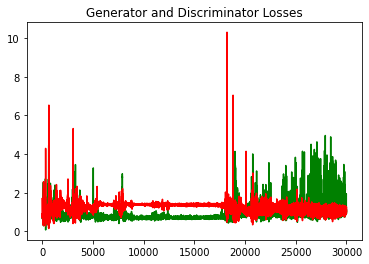

In [ ]:
plot_losses(gloss, dloss)

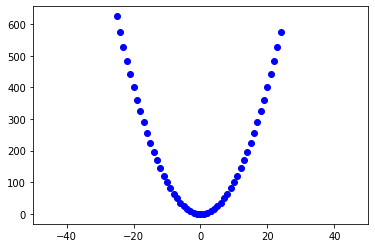

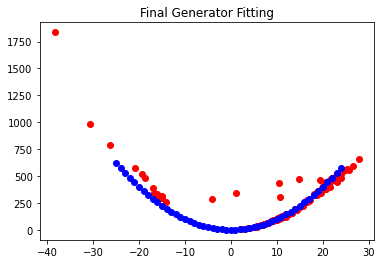

In [ ]:
make_anim(gen_list, parabolic_dist, 25)

**Fit Inverse Parabola**

In [ ]:
#train to fit simple function -(x^2)
z_dim = 10
num_epochs = 40000
batch_size = 32

device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")

criterion = nn.BCELoss()
generator = Generator(z_dim=z_dim, hidden_dim=28, n_layers=3, out_dim=2).to(device)
discriminator = Discriminator(input_dim=2, hidden_dim=28, n_layers=3).to(device)

optimizerD = optim.Adam(discriminator.parameters())
optimizerG = optim.Adam(generator.parameters())
fixed_noise = torch.randn(128, z_dim, device=device)

generator, discriminator, gloss, dloss, gen_list = train(generator, discriminator, optimizerG, optimizerD, inverse_parabolic_dist, criterion, fixed_noise, r=50, z_dim=z_dim, num_epochs=num_epochs, batch_size=batch_size, device=device)

Training...
cpu
[0/40000]	Loss_D: 2.9306	Loss_G: 0.6259
[50/40000]	Loss_D: 0.7692	Loss_G: 0.7120
[100/40000]	Loss_D: 1.1350	Loss_G: 0.7378
[150/40000]	Loss_D: 1.5501	Loss_G: 0.4866
[200/40000]	Loss_D: 0.9114	Loss_G: 1.3091
[250/40000]	Loss_D: 1.0714	Loss_G: 1.0803
[300/40000]	Loss_D: 1.2755	Loss_G: 0.9422
[350/40000]	Loss_D: 0.9221	Loss_G: 1.1156
[400/40000]	Loss_D: 1.2721	Loss_G: 0.5515
[450/40000]	Loss_D: 0.9628	Loss_G: 1.0744
[500/40000]	Loss_D: 0.7624	Loss_G: 0.6468
[550/40000]	Loss_D: 0.9648	Loss_G: 0.7496
[600/40000]	Loss_D: 0.7850	Loss_G: 0.7626
[650/40000]	Loss_D: 0.5507	Loss_G: 1.1636
[700/40000]	Loss_D: 0.4370	Loss_G: 1.7366
[750/40000]	Loss_D: 0.6231	Loss_G: 1.8696
[800/40000]	Loss_D: 0.9524	Loss_G: 1.7892
[850/40000]	Loss_D: 1.8340	Loss_G: 0.7469
[900/40000]	Loss_D: 0.6381	Loss_G: 1.7372
[950/40000]	Loss_D: 2.1637	Loss_G: 2.2504
[1000/40000]	Loss_D: 0.6871	Loss_G: 1.3970
[1050/40000]	Loss_D: 0.9652	Loss_G: 1.5895
[1100/40000]	Loss_D: 0.1761	Loss_G: 2.6379
[1150/40000]	Loss_

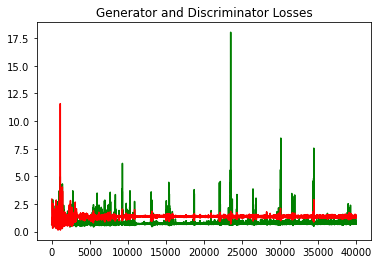

In [ ]:
plot_losses(gloss, dloss)

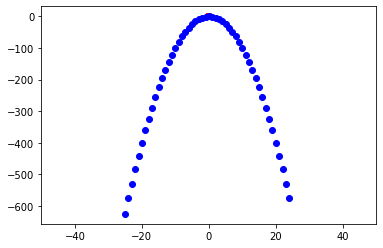

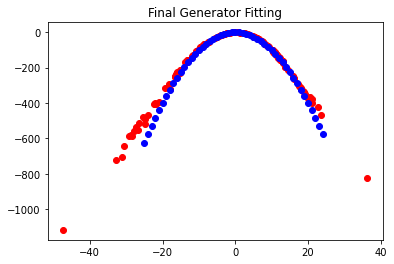

In [ ]:
make_anim(gen_list, inverse_parabolic_dist, 25)

**Fit 2D Gaussian**

In [ ]:
#train to fit 2d gaussian
z_dim = 10
num_epochs = 40000
batch_size = 256

device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")

criterion = nn.BCELoss()
generator = Generator(z_dim=z_dim, hidden_dim=28, n_layers=3, out_dim=2).to(device)
discriminator = Discriminator(input_dim=2, hidden_dim=28, n_layers=3).to(device)

optimizerD = optim.Adam(discriminator.parameters())
optimizerG = optim.Adam(generator.parameters())
fixed_noise = torch.randn(1024, z_dim, device=device)

generator, discriminator, gloss, dloss, gen_list = train(generator, discriminator, optimizerG, optimizerD, gauss_2d, criterion, fixed_noise, r=50, z_dim=z_dim, num_epochs=num_epochs, batch_size=batch_size, mode='2d', device=device)

Training...
cpu
[0/40000]	Loss_D: 1.3916	Loss_G: 0.6626
[50/40000]	Loss_D: 1.2101	Loss_G: 0.6993
[100/40000]	Loss_D: 0.9012	Loss_G: 1.2410
[150/40000]	Loss_D: 1.0001	Loss_G: 1.3833
[200/40000]	Loss_D: 1.5583	Loss_G: 0.8876
[250/40000]	Loss_D: 1.2133	Loss_G: 0.7565
[300/40000]	Loss_D: 1.0750	Loss_G: 0.6959
[350/40000]	Loss_D: 0.8017	Loss_G: 1.7416
[400/40000]	Loss_D: 1.1055	Loss_G: 1.0140
[450/40000]	Loss_D: 1.2730	Loss_G: 0.8154
[500/40000]	Loss_D: 0.6240	Loss_G: 1.6741
[550/40000]	Loss_D: 1.0766	Loss_G: 0.9155
[600/40000]	Loss_D: 1.3149	Loss_G: 1.2054
[650/40000]	Loss_D: 0.9327	Loss_G: 1.1358
[700/40000]	Loss_D: 0.6133	Loss_G: 1.1862
[750/40000]	Loss_D: 1.1480	Loss_G: 1.2906
[800/40000]	Loss_D: 1.3342	Loss_G: 1.9339
[850/40000]	Loss_D: 1.2459	Loss_G: 1.1703
[900/40000]	Loss_D: 1.1509	Loss_G: 0.9822
[950/40000]	Loss_D: 1.0307	Loss_G: 1.0580
[1000/40000]	Loss_D: 1.0837	Loss_G: 0.8543
[1050/40000]	Loss_D: 1.2922	Loss_G: 0.6004
[1100/40000]	Loss_D: 0.9074	Loss_G: 1.7538
[1150/40000]	Loss_

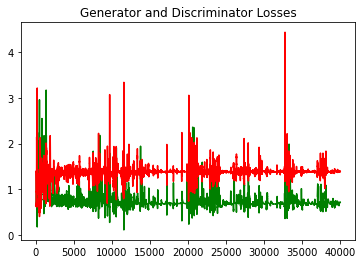

In [ ]:
plot_losses(gloss, dloss)

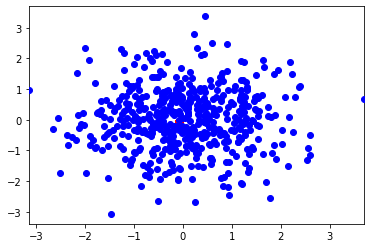

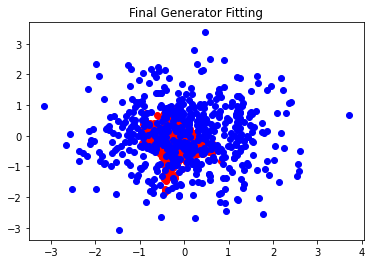

In [ ]:
make_anim(gen_list, gauss_2d, 512, mode='2d')